In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/danish003/face-images-of-acute-stroke-and-non-acute-stroke")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ahmedishere
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/danish003/face-images-of-acute-stroke-and-non-acute-stroke


100%|██████████| 36.7M/36.7M [00:01<00:00, 19.4MB/s]


In [20]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from keras.layers import Conv2D,MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.applications import VGG19
from keras.models import Sequential
import matplotlib.pyplot as plt
from matplotlib import pyplot
import tensorflow as tf
import pandas as pd
import numpy as np
import os

In [4]:
def create_dataframe(root_dir):
    data = []
    for class_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                data.append({'file_path': file_path, 'class': class_name})
    return pd.DataFrame(data)

In [5]:
root_path = 'face-images-of-acute-stroke-and-non-acute-stroke/main'
dataset = create_dataframe(root_path)

In [6]:
train_df, test_df = train_test_split(dataset, test_size=0.2, stratify=dataset['class'], random_state=42)

In [7]:
training_data_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=30
)

In [8]:
testing_data_generator = ImageDataGenerator(rescale=1./255)

In [9]:
training_data = training_data_generator.flow_from_dataframe(
    train_df,
    x_col='file_path',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 3016 validated image filenames belonging to 2 classes.


In [10]:
testing_data = testing_data_generator.flow_from_dataframe(
    test_df,
    x_col='file_path',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 754 validated image filenames belonging to 2 classes.


In [11]:
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model.trainable = False

80134624/80134624 [==============================] - 4s 0us/step


In [12]:
model = Sequential()
model.add(vgg_model)
model.add(Conv2D(32,(3,3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())

model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          147488    
                                                                 
 max_pooling2d (MaxPooling2  (None, 2, 2, 32)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

In [14]:
history = model.fit(training_data, epochs=10, validation_data=testing_data)

Epoch 1/10
95/95 [==============================] - 68s 559ms/step - loss: 0.4534 - accuracy: 0.7755 - val_loss: 0.1893 - val_accuracy: 0.9231
Epoch 2/10
95/95 [==============================] - 47s 492ms/step - loss: 0.2363 - accuracy: 0.9058 - val_loss: 0.1311 - val_accuracy: 0.9562
Epoch 3/10
95/95 [==============================] - 46s 479ms/step - loss: 0.1534 - accuracy: 0.9380 - val_loss: 0.0782 - val_accuracy: 0.9721
Epoch 4/10
95/95 [==============================] - 46s 483ms/step - loss: 0.1306 - accuracy: 0.9473 - val_loss: 0.0602 - val_accuracy: 0.9814
Epoch 5/10
95/95 [==============================] - 46s 481ms/step - loss: 0.1171 - accuracy: 0.9556 - val_loss: 0.0501 - val_accuracy: 0.9814
Epoch 6/10
95/95 [==============================] - 46s 483ms/step - loss: 0.0786 - accuracy: 0.9698 - val_loss: 0.0483 - val_accuracy: 0.9841
Epoch 7/10
95/95 [==============================] - 46s 482ms/step - loss: 0.0825 - accuracy: 0.9721 - val_loss: 0.0397 - val_accuracy: 0.9854

In [15]:
loss, accuracy = model.evaluate(testing_data)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

24/24 [==============================] - 4s 165ms/step - loss: 0.1029 - accuracy: 0.9668
Test Accuracy: 96.68%


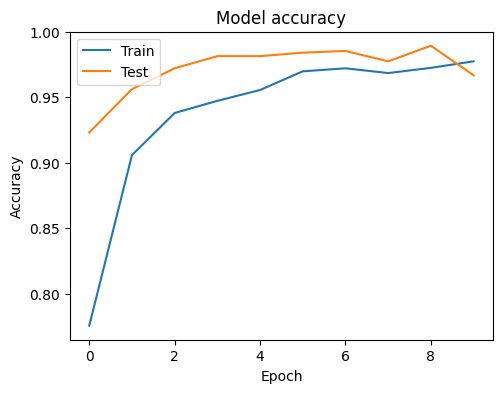

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

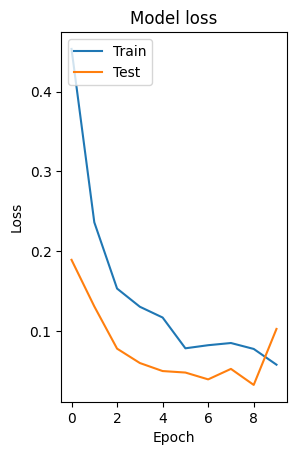

In [17]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

## Testing

In [24]:
def predict_image(image_path):
  img = image.load_img(image_path, target_size=(224, 224))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0
  prediction = model.predict(img_array)
  class_label = 'acute stroke' if prediction[0] > 0.5 else 'non-acute stroke'
  return class_label

In [25]:
image_path = '/content/face-images-of-acute-stroke-and-non-acute-stroke/main/stroke_data/aug_0_1006.jpg'
predicted_class, confidence = predict_image(image_path)
print(f'Predicted Class: {predicted_class}')

1/1 [==============================] - 0s 18ms/step
Predicted Class: acute stroke
